In [104]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import torch
import numpy as np
import networkx as nx
from tqdm import tqdm_notebook as tqdm
from pysal.inequality.gini import Gini

from method.learned_cn_method import CNModule, LCIModule
from data import load_network
from util import Params, prepare_sns
from data import load_diseases, load_network

prepare_sns(sns, {})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
diseases_dict = load_diseases("../../data/associations/disgenet-associations.csv")
m = len(diseases_dict)
print("Loaded {} diseases.".format(m))

Loaded 2297 diseases.


In [106]:
ppi_networkx, ppi_network_adj, protein_to_node = load_network("../../data/networks/bio-pathways-network.txt")
n = ppi_network_adj.shape[0]
node_to_protein = {node: protein for protein, node in protein_to_node.items()}

In [107]:
m = len(diseases_dict.values())
diseases = np.zeros((m, n), dtype=int)
index_to_disease = []
for i, disease in enumerate(diseases_dict.values()):
    disease_nodes = disease.to_node_array(protein_to_node)
    diseases[i, disease_nodes] = 1
    index_to_disease.append(disease)

## Common Interactions

Question: What fraction of common interactions go through node i?
Question: What fraction of diseases 

In [59]:
def compute_common_interactors(diseases_dict, adj): 
    ci_pairs = [set() for i in range(n)]
    ci_diseases = [set() for i in range(n)]
    for disease in tqdm(diseases_dict.values()):
        proteins = disease.to_node_array(protein_to_node)
        for protein_a in proteins:
            for protein_b in proteins:
                if protein_a == protein_b:
                    continue 
                neighbors_a = adj[protein_a, :]
                neighbors_b = adj[protein_b, :]
                cis = np.where(np.multiply(neighbors_a, neighbors_b) == 1)[0]
                for ci in cis:
                    ci_pairs[ci].add(tuple(sorted((protein_a, protein_b))))
                    ci_diseases[ci].add(disease.id)
    return ci_pairs, ci_diseases

In [61]:
ci_pairs, ci_diseases = compute_common_interactors(diseases_dict, ppi_network_adj)

In [111]:
all_ci_pairs = set.union(*ci_pairs)

In [134]:
ci_n_pairs = np.array(map(len, ci_pairs))

In [117]:
# How many pairs of proteins are there that share a common interactor? 
print("{} proteins").format(len(all_ci_pairs))

857448 proteins


Text(0,0.5,'# of common interactors [log]')

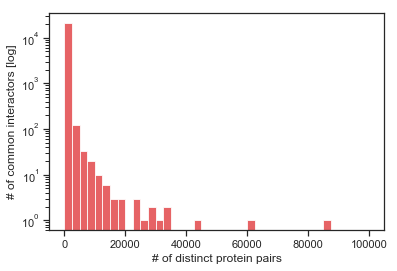

In [121]:
plt.hist(ci_n_pairs, 40, range=(0, 100000), alpha=0.8)
plt.yscale('log')
plt.xlabel('# of distinct protein pairs')
plt.ylabel('# of common interactors [log]')

In [56]:
# What is the GINI coefficient of 
Gini(n_pairs).g

0.9337597899800635

In [133]:
# How many protein pairs do common interactors have on average? 
print("{} protein pairs on average".format(np.sum(ci_n_pairs) / np.count_nonzero(ci_n_pairs)))

233 protein pairs on average


In [135]:
# Which proteins are common interactors for the most distinct pairs?
node_to_protein = {node: protein for protein, node in protein_to_node.items()}
[node_to_protein[node] for node in np.argsort(-1 * ci_n_pairs)][:10]

[4914, 351, 1994, 2885, 7157, 1956, 7316, 3320, 1017, 8452]

### Associated Diseases
For each protein i, we compute a) how many diseases i is directly associated with and b) For how many diseases does there exist a pair of associated proteins that share protein i as a common interactor? 

In [114]:
# How many diseases is protein i directly associated with
protein_n_diseases = np.sum(diseases, axis=0)
# For how many diseases does there exist a pair of associated proteins that share
# protein i as a common interactor? 
ci_n_diseases = np.array(map(len, ci_diseases))

Text(0,0.5,'# of proteins')

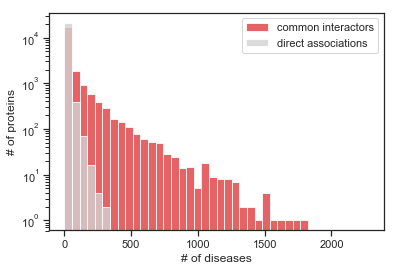

In [124]:
plt.hist(ci_n_diseases, 40, range=(0, 2279), alpha=0.8, label="common interactors")
plt.hist(protein_n_diseases, 40, range=(0, 2279), alpha=0.8, color='#D3D3D3', label="direct associations")
plt.yscale('log')
plt.legend()
plt.xlabel('# of diseases')
plt.ylabel('# of proteins')


In [132]:
# Which proteins are common interactors for the most diseases? 
node_to_protein = {node: protein for protein, node in protein_to_node.items()}
[node_to_protein[node] for node in np.argsort(-1 * ci_n_diseases)][:10]

[4914, 2885, 351, 1994, 3320, 7316, 7157, 1956, 6667, 1017]

In [131]:
# Which proteins are associated with the most diseases? 
node_to_protein = {node: protein for protein, node in protein_to_node.items()}
[node_to_protein[node] for node in np.argsort(-1 * protein_n_diseases)][:10]

[4000, 2263, 673, 3845, 2316, 2261, 2260, 5728, 2006, 1280]